In [1]:
import scvi
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

Global seed set to 0


In [2]:
sklearn.__version__

'0.24.2'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.mixture import GaussianMixture

def classify_with_gmm(x, n_components):
    gm = GaussianMixture(n_components=n_components).fit(x)
    return gm, gm.predict_proba(x), gm.means_

def classify_infection(adata, genes, save_key, batch_key, n_components):
    batches = list(np.unique(adata.obs[batch_key]))
    probs_save_key = save_key+'_probs'
    
    adata.obs[save_key] = 'na'
    adata.obsm[probs_save_key] = pd.DataFrame(index=adata.obs_names, data=np.zeros((adata.n_obs, n_components)))
    bics={}
    for batch in batches:
        batch_adata = adata[adata.obs[batch_key] == batch]

        probs = np.zeros((batch_adata.n_obs, n_components))
        tmp_bics = []
        for gene in genes:
            x = np.array(batch_adata.obs[gene]).reshape(-1, 1)
            gm, prob, means = classify_with_gmm(x, n_components=n_components)
            bic = gm.bic(x)
            
            index = np.argsort(means.flatten())
            prob[:] = prob[:, index]
            probs = np.add(probs,prob)
            tmp_bics.append(bic)
            
        bics[batch] = np.mean(np.array(tmp_bics))

        adata.obs[save_key][batch_adata.obs_names] = np.argmax(probs, axis=1)
        adata.obs[save_key] = adata.obs[save_key].astype(str)
        adata.obsm[probs_save_key].loc[batch_adata.obs_names] = probs
        
    bics = pd.DataFrame.from_dict(bics, orient='index', columns=[save_key])
    return bics

In [5]:
adata_fn = '../data/round1round2_processed.h5ad'

adata = anndata.read(adata_fn)

In [6]:
batch_key = "round_variant_condition"
variants = list(np.unique(adata.obs[batch_key]))

# 3 components on each individual gene

In [7]:
n_components = 3

save_key='gmm_3_infection_individual'

variants= list(np.unique(adata.obs[batch_key]))

sars_genes = [g for g in adata.var_names if g.startswith('SARS2_genome')]
sars_genes = [g+'_log' for g in sars_genes]

bics_3_ind = classify_infection(adata=adata,
                   genes=sars_genes, 
                   save_key=save_key,
                   batch_key=batch_key,
                   n_components=n_components
                  )

In [8]:
adata

AnnData object with n_obs × n_vars = 38462 × 36611
    obs: 'infection', 'variant', 'condition', 'library_size', 'library_size_log', 'SARS2_genome_ORF1ab_counts', 'SARS2_genome_ORF1ab_log', 'SARS2_genome_S_counts', 'SARS2_genome_S_log', 'SARS2_genome_ORF3a_counts', 'SARS2_genome_ORF3a_log', 'SARS2_genome_E_counts', 'SARS2_genome_E_log', 'SARS2_genome_M_counts', 'SARS2_genome_M_log', 'SARS2_genome_ORF6_counts', 'SARS2_genome_ORF6_log', 'SARS2_genome_ORF7a_counts', 'SARS2_genome_ORF7a_log', 'SARS2_genome_ORF8_counts', 'SARS2_genome_ORF8_log', 'SARS2_genome_N_counts', 'SARS2_genome_N_log', 'SARS2_genome_ORF10_counts', 'SARS2_genome_ORF10_log', 'sars2_total_counts', 'sars2_total_counts_log', 'sars2_lib_size_ratio', 'round', 'condition_variant', 'round_variant_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_3_infection_individual'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'gmm_3_infection_in

In [9]:
total_prob = adata.obsm['gmm_3_infection_individual_probs'].sum(axis=1)


(array([ 1536.,  1357.,   758.,   689., 10094.,   541.,   901.,  8075.,
         5011.,  9500.]),
 array([0.        , 0.09999987, 0.19999974, 0.29999961, 0.39999948,
        0.49999935, 0.59999922, 0.69999909, 0.79999896, 0.89999883,
        0.9999987 ]),
 <BarContainer object of 10 artists>)

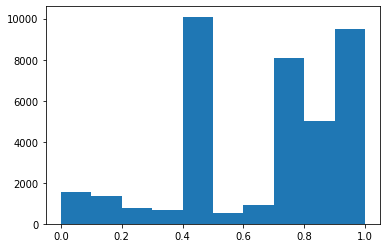

In [10]:
plt.hist(adata.obsm['gmm_3_infection_individual_probs'].divide(total_prob, axis=0)[0])

In [11]:
adata.obs.groupby(['round_variant_condition', save_key]).size().unstack(level=1)

gmm_3_infection_individual,0,1,2
round_variant_condition,,,
round_1_Uninfected_1_ACE2,0,9519,0
round_1_Uninfected_1_WT,4584,0,0
round_1_WA1_1_ACE2,5813,1505,647
round_1_WA1_1_WT,5702,2,75
round_2_B.1.1.7_ACE2,1434,37,217
round_2_B.1.351_ACE2,1749,79,304
round_2_B.1.351_delta_ACE2,1198,487,594
round_2_B.1.429_ACE2,1111,142,158
round_2_Uninfected_2_ACE2,1161,0,0


# 3 components on total sum

In [12]:
adata

AnnData object with n_obs × n_vars = 38462 × 36611
    obs: 'infection', 'variant', 'condition', 'library_size', 'library_size_log', 'SARS2_genome_ORF1ab_counts', 'SARS2_genome_ORF1ab_log', 'SARS2_genome_S_counts', 'SARS2_genome_S_log', 'SARS2_genome_ORF3a_counts', 'SARS2_genome_ORF3a_log', 'SARS2_genome_E_counts', 'SARS2_genome_E_log', 'SARS2_genome_M_counts', 'SARS2_genome_M_log', 'SARS2_genome_ORF6_counts', 'SARS2_genome_ORF6_log', 'SARS2_genome_ORF7a_counts', 'SARS2_genome_ORF7a_log', 'SARS2_genome_ORF8_counts', 'SARS2_genome_ORF8_log', 'SARS2_genome_N_counts', 'SARS2_genome_N_log', 'SARS2_genome_ORF10_counts', 'SARS2_genome_ORF10_log', 'sars2_total_counts', 'sars2_total_counts_log', 'sars2_lib_size_ratio', 'round', 'condition_variant', 'round_variant_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_3_infection_individual'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'gmm_3_infection_in

In [13]:
n_components = 3

save_key='gmm_3_infection_total'

variants= list(np.unique(adata.obs[batch_key]))

sars_genes = ['sars2_total_counts_log']
bics_3_total = classify_infection(adata=adata,
                   genes=sars_genes, 
                   save_key=save_key,
                   batch_key=batch_key,
                   n_components=n_components
                  )

# 2 components on each individual gene

In [14]:
n_components = 2

save_key='gmm_2_infection_individual'
variants= list(np.unique(adata.obs[batch_key]))

sars_genes = ['sars2_total_counts_log']
bics_2_ind = classify_infection(adata=adata,
                   genes=sars_genes, 
                   save_key=save_key,
                   batch_key=batch_key,
                   n_components=n_components
                  )

# 2 components on total sum

In [15]:
n_components = 2

save_key='gmm_2_infection_total'

variants= list(np.unique(adata.obs[batch_key]))

sars_genes = [g for g in adata.var_names if g.startswith('SARS2_genome')]
sars_genes = [g+'_log' for g in sars_genes]

bics_2_total = classify_infection(adata=adata,
                   genes=sars_genes, 
                   save_key=save_key,
                   batch_key=batch_key,
                   n_components=n_components
                  )

In [16]:
adata

AnnData object with n_obs × n_vars = 38462 × 36611
    obs: 'infection', 'variant', 'condition', 'library_size', 'library_size_log', 'SARS2_genome_ORF1ab_counts', 'SARS2_genome_ORF1ab_log', 'SARS2_genome_S_counts', 'SARS2_genome_S_log', 'SARS2_genome_ORF3a_counts', 'SARS2_genome_ORF3a_log', 'SARS2_genome_E_counts', 'SARS2_genome_E_log', 'SARS2_genome_M_counts', 'SARS2_genome_M_log', 'SARS2_genome_ORF6_counts', 'SARS2_genome_ORF6_log', 'SARS2_genome_ORF7a_counts', 'SARS2_genome_ORF7a_log', 'SARS2_genome_ORF8_counts', 'SARS2_genome_ORF8_log', 'SARS2_genome_N_counts', 'SARS2_genome_N_log', 'SARS2_genome_ORF10_counts', 'SARS2_genome_ORF10_log', 'sars2_total_counts', 'sars2_total_counts_log', 'sars2_lib_size_ratio', 'round', 'condition_variant', 'round_variant_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_3_infection_individual', 'gmm_3_infection_total', 'gmm_2_infection_individual', 'gmm_2_infection_total'
    var: 'mt', 'n_cells_by_counts', 'mea

In [17]:
bics_2_total

,gmm_2_infection_total
round_1_Uninfected_1_ACE2,-113899.650722
round_1_Uninfected_1_WT,-54832.072060
round_1_WA1_1_ACE2,-32369.066617
round_1_WA1_1_WT,-64461.895437
round_2_B.1.1.7_ACE2,-8310.241770
round_2_B.1.351_ACE2,-6883.390517
round_2_B.1.351_delta_ACE2,-2686.916659
round_2_B.1.429_ACE2,-5443.894786
round_2_Uninfected_2_ACE2,-13863.350377
round_2_WA1_2_ACE2,-10088.444748


In [18]:
bics_2_ind

,gmm_2_infection_individual
round_1_Uninfected_1_ACE2,-113193.671082
round_1_Uninfected_1_WT,-54611.545828
round_1_WA1_1_ACE2,28522.587629
round_1_WA1_1_WT,-48571.954197
round_2_B.1.1.7_ACE2,5980.030978
round_2_B.1.351_ACE2,7896.354643
round_2_B.1.351_delta_ACE2,11138.070818
round_2_B.1.429_ACE2,5637.624163
round_2_Uninfected_2_ACE2,-13806.292872
round_2_WA1_2_ACE2,6115.790706


In [19]:
bics_3_total

,gmm_3_infection_total
round_1_Uninfected_1_ACE2,-113476.575271
round_1_Uninfected_1_WT,-54676.441594
round_1_WA1_1_ACE2,28548.488857
round_1_WA1_1_WT,-50332.614295
round_2_B.1.1.7_ACE2,6001.281735
round_2_B.1.351_ACE2,7826.212454
round_2_B.1.351_delta_ACE2,9607.095150
round_2_B.1.429_ACE2,5624.949191
round_2_Uninfected_2_ACE2,-13785.121761
round_2_WA1_2_ACE2,6133.019038


In [20]:
bics_3_ind

,gmm_3_infection_individual
round_1_Uninfected_1_ACE2,-113884.937095
round_1_Uninfected_1_WT,-54812.283847
round_1_WA1_1_ACE2,-36550.035029
round_1_WA1_1_WT,-65477.448326
round_2_B.1.1.7_ACE2,-9941.420163
round_2_B.1.351_ACE2,-10326.998375
round_2_B.1.351_delta_ACE2,-7467.635457
round_2_B.1.429_ACE2,-6465.213418
round_2_Uninfected_2_ACE2,-13842.179266
round_2_WA1_2_ACE2,-12025.745099


In [21]:
bics = pd.concat((bics_2_ind, bics_2_total, bics_3_ind, bics_3_total), axis=1)

In [22]:
bics

,gmm_2_infection_individual,gmm_2_infection_total,gmm_3_infection_individual,gmm_3_infection_total
round_1_Uninfected_1_ACE2,-113193.671082,-113899.650722,-113884.937095,-113476.575271
round_1_Uninfected_1_WT,-54611.545828,-54832.072060,-54812.283847,-54676.441594
round_1_WA1_1_ACE2,28522.587629,-32369.066617,-36550.035029,28548.488857
round_1_WA1_1_WT,-48571.954197,-64461.895437,-65477.448326,-50332.614295
round_2_B.1.1.7_ACE2,5980.030978,-8310.241770,-9941.420163,6001.281735
round_2_B.1.351_ACE2,7896.354643,-6883.390517,-10326.998375,7826.212454
round_2_B.1.351_delta_ACE2,11138.070818,-2686.916659,-7467.635457,9607.095150
round_2_B.1.429_ACE2,5637.624163,-5443.894786,-6465.213418,5624.949191
round_2_Uninfected_2_ACE2,-13806.292872,-13863.350377,-13842.179266,-13785.121761
round_2_WA1_2_ACE2,6115.790706,-10088.444748,-12025.745099,6133.019038


In [23]:
best_model = bics.idxmin(axis=1)

In [24]:
best_model

round_1_Uninfected_1_ACE2          gmm_2_infection_total
round_1_Uninfected_1_WT            gmm_2_infection_total
round_1_WA1_1_ACE2            gmm_3_infection_individual
round_1_WA1_1_WT              gmm_3_infection_individual
round_2_B.1.1.7_ACE2          gmm_3_infection_individual
round_2_B.1.351_ACE2          gmm_3_infection_individual
round_2_B.1.351_delta_ACE2    gmm_3_infection_individual
round_2_B.1.429_ACE2          gmm_3_infection_individual
round_2_Uninfected_2_ACE2          gmm_2_infection_total
round_2_WA1_2_ACE2            gmm_3_infection_individual
dtype: object

In [25]:
adata.obs['gmm_infection'] = 'na'
for batch, model in zip(best_model.index, best_model.values):
    batch_cells = adata[adata.obs.round_variant_condition==batch].obs_names
    adata.obs['gmm_infection'][batch_cells] =  adata.obs[model][batch_cells]

In [26]:
adata

AnnData object with n_obs × n_vars = 38462 × 36611
    obs: 'infection', 'variant', 'condition', 'library_size', 'library_size_log', 'SARS2_genome_ORF1ab_counts', 'SARS2_genome_ORF1ab_log', 'SARS2_genome_S_counts', 'SARS2_genome_S_log', 'SARS2_genome_ORF3a_counts', 'SARS2_genome_ORF3a_log', 'SARS2_genome_E_counts', 'SARS2_genome_E_log', 'SARS2_genome_M_counts', 'SARS2_genome_M_log', 'SARS2_genome_ORF6_counts', 'SARS2_genome_ORF6_log', 'SARS2_genome_ORF7a_counts', 'SARS2_genome_ORF7a_log', 'SARS2_genome_ORF8_counts', 'SARS2_genome_ORF8_log', 'SARS2_genome_N_counts', 'SARS2_genome_N_log', 'SARS2_genome_ORF10_counts', 'SARS2_genome_ORF10_log', 'sars2_total_counts', 'sars2_total_counts_log', 'sars2_lib_size_ratio', 'round', 'condition_variant', 'round_variant_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_3_infection_individual', 'gmm_3_infection_total', 'gmm_2_infection_individual', 'gmm_2_infection_total', 'gmm_infection'
    var: 'mt', 'n_cells

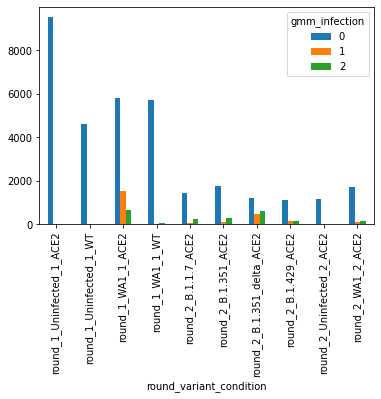

In [27]:
df = adata.obs
ax = df.groupby(['round_variant_condition', 'gmm_infection']).size().unstack(level=1).plot(kind='bar')


In [28]:

df.groupby(['round_variant_condition', 'gmm_infection']).size().unstack(level=1)


gmm_infection,0,1,2
round_variant_condition,,,
round_1_Uninfected_1_ACE2,9519,0,0
round_1_Uninfected_1_WT,4584,0,0
round_1_WA1_1_ACE2,5813,1505,647
round_1_WA1_1_WT,5702,2,75
round_2_B.1.1.7_ACE2,1434,37,217
round_2_B.1.351_ACE2,1749,79,304
round_2_B.1.351_delta_ACE2,1198,487,594
round_2_B.1.429_ACE2,1111,142,158
round_2_Uninfected_2_ACE2,1161,0,0


In [29]:
infection_df = adata.obs.groupby(['round_variant_condition', 'gmm_infection']).size().unstack(level=1)

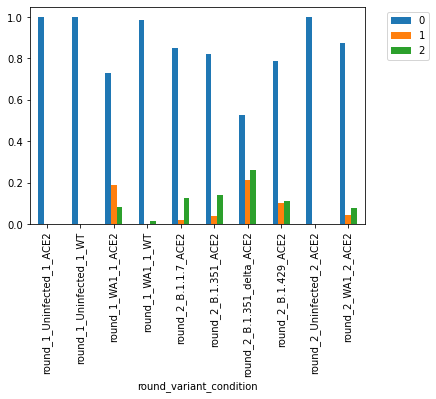

In [30]:
ax = infection_df.divide(infection_df.sum(axis=1), axis=0).plot(kind='bar')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [33]:

keys = list(adata.obsm.keys())
for key in keys:
    if key.endswith('_probs'):
        del adata.obsm[key]

In [34]:
adata

AnnData object with n_obs × n_vars = 38462 × 36611
    obs: 'infection', 'variant', 'condition', 'library_size', 'library_size_log', 'SARS2_genome_ORF1ab_counts', 'SARS2_genome_ORF1ab_log', 'SARS2_genome_S_counts', 'SARS2_genome_S_log', 'SARS2_genome_ORF3a_counts', 'SARS2_genome_ORF3a_log', 'SARS2_genome_E_counts', 'SARS2_genome_E_log', 'SARS2_genome_M_counts', 'SARS2_genome_M_log', 'SARS2_genome_ORF6_counts', 'SARS2_genome_ORF6_log', 'SARS2_genome_ORF7a_counts', 'SARS2_genome_ORF7a_log', 'SARS2_genome_ORF8_counts', 'SARS2_genome_ORF8_log', 'SARS2_genome_N_counts', 'SARS2_genome_N_log', 'SARS2_genome_ORF10_counts', 'SARS2_genome_ORF10_log', 'sars2_total_counts', 'sars2_total_counts_log', 'sars2_lib_size_ratio', 'round', 'condition_variant', 'round_variant_condition', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_3_infection_individual', 'gmm_3_infection_total', 'gmm_2_infection_individual', 'gmm_2_infection_total', 'gmm_infection'
    var: 'mt', 'n_cells

In [35]:
adata.obs['infection_gmm'] = adata.obs['infection'].astype(str) + '_' + adata.obs['gmm_infection'].astype(str)

adata.obs['infection_gmm'].value_counts()
adata.obs['infection_gmm_annotated'] = adata.obs['infection_gmm'].replace({'U_0':'Uninfected',
                                    'I_0':"No Infection",
                                    'I_1': "Low Infection",
                                    'I_2': 'High Infection'
                                   })


In [36]:
adata.write(adata_fn)

... storing 'gmm_3_infection_individual' as categorical
... storing 'gmm_3_infection_total' as categorical
... storing 'gmm_2_infection_individual' as categorical
... storing 'gmm_2_infection_total' as categorical
... storing 'gmm_infection' as categorical
... storing 'infection_gmm' as categorical
... storing 'infection_gmm_annotated' as categorical


In [37]:
adata[adata.obs['round']=='round_1'].write('round1_processed.h5ad')

In [38]:
adata[adata.obs['round']=='round_2'].write('round2_processed.h5ad')